In [1]:
import random
import os
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
from facerecognitionmodel import FaceRecognitionModel
from tqdm import tqdm

/home/ebneto/miniconda3/envs/pl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def person_name_from_filepath(filepath):
    return filepath.split('/')[1]

def list_files_in_directory(path):
    filepaths = []
    for root, _, files in os.walk(path):
        for file in files:
            file_path = os.path.join(root, file)
            filepaths.append(file_path)

    return filepaths

myfiles = list_files_in_directory('data')
for path in random.choices(myfiles, k=10):
    print(person_name_from_filepath(path))

Linda_Lingle
Herb_Sendek
Lauren_Killian
Antonio_Banderas
Tatjana_Gsell
Carol_Burnett
Micky_Ward
Chakib_Khelil
Alecos_Markides
William_Bratton


In [3]:
class PersonsDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.pictures = list_files_in_directory(root_dir)
    
    def __len__(self):
        return len(self.pictures)
    
    def __getitem__(self, idx):
        picture_path = self.pictures[idx]
        picture = np.asarray(Image.open(picture_path)).transpose(2, 0, 1)
        picture = picture.astype(np.float32) / 255.

        person_name = person_name_from_filepath(picture_path)
        return picture, person_name        

Text(0.5, 1.0, 'Laura_Bush')

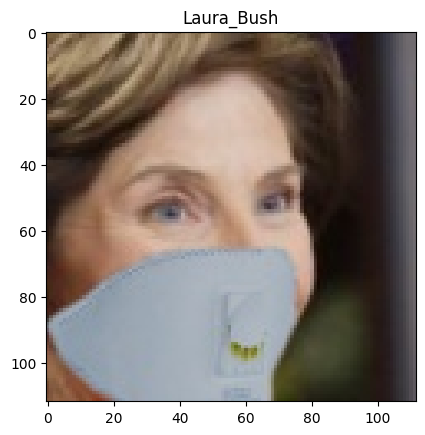

In [4]:
# testing our dataset
persons_dataset = PersonsDataset('data')
picture, person_name = random.choice(persons_dataset)
plt.imshow(picture.transpose(1, 2, 0))
plt.title(person_name)

In [6]:
model = FaceRecognitionModel.load_from_checkpoint('lightning_logs/version_10/checkpoints/epoch=8-step=3366.ckpt')
model.eval()

known_embeddings = []
known_names = []
loop = tqdm(persons_dataset, total=len(persons_dataset), desc='Building embedding database')

with torch.no_grad():
    for picture, name in loop:
        picture = torch.Tensor(picture).to('cuda')
        picture = picture.unsqueeze(0)
        embedding = model.get_embedding(picture).cpu().numpy()
        known_embeddings.append(embedding)
        known_names.append(name)


Building embedding database: 100%|██████████| 12000/12000 [03:36<00:00, 55.39it/s]


In [7]:
assert len(known_embeddings) == len(known_names)
assert len(known_embeddings) == len(persons_dataset)
print(f'Ok!')

Ok!


In [8]:
def calculate_similarity(embedding1, embedding2):
    # Calculate cosine similarity between embeddings
    similarity = torch.nn.functional.cosine_similarity(embedding1, embedding2)
    return similarity.item()

Text(0.5, 1.0, 'Michel_Temer')

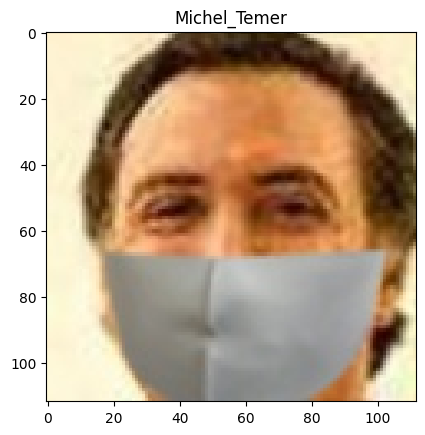

In [13]:
person_img, person_name = random.choice(persons_dataset)

while person_name != 'Michel_Temer':
    person_img, person_name = random.choice(persons_dataset)

plt.imshow(person_img.transpose(1, 2, 0))
plt.title(person_name)

In [14]:
from heapq import nlargest
from pprint import pprint   
with torch.no_grad():
    query_embedding = model.get_embedding(torch.Tensor(person_img).to('cuda').unsqueeze(0))
sim_scores = []
loop = tqdm(zip(known_embeddings, known_names), total=len(known_embeddings), desc='Calculating similarity')
for known_embedding, known_name in loop:
    known_embedding = torch.Tensor(known_embedding).to('cuda')
    similarity = calculate_similarity(query_embedding, known_embedding)
    sim_scores.append((known_name, similarity))

top_matches = nlargest(10, sim_scores, key=lambda x: x[1])
pprint(top_matches)

Calculating similarity:   0%|          | 0/12000 [00:00<?, ?it/s]

Calculating similarity: 100%|██████████| 12000/12000 [00:02<00:00, 5519.16it/s]

[('Michel_Temer', 1.000000238418579),
 ('Justin_Gatlin', 0.9687057137489319),
 ('Carlton_Dotson', 0.968424916267395),
 ('Erika_Harold', 0.9675120711326599),
 ('Lucio_Gutierrez', 0.9671690464019775),
 ('Steve_Karsay', 0.96389240026474),
 ('Giuseppe_Morchio', 0.9624862670898438),
 ('Marcos_Cafu', 0.9620828628540039),
 ('Herb_Sendek', 0.9609512090682983),
 ('Tavis_Smiley', 0.9606420993804932)]


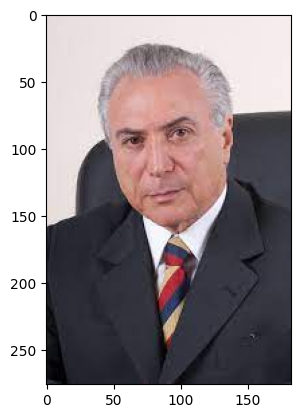

In [15]:
temer = Image.open('michelzinho.jpeg')
temer = np.asarray(temer).transpose(2, 0, 1)
temer = np.float32(temer) / 255.
plt.imshow(temer.transpose(1, 2, 0))

In [16]:
temer_embed = model.get_embedding(torch.Tensor(temer).to('cuda').unsqueeze(0))
sim_scores = []
loop = tqdm(zip(known_embeddings, known_names), total=len(known_embeddings), desc='Calculating similarity')
for known_embedding, known_name in loop:
    known_embedding = torch.Tensor(known_embedding).to('cuda')
    similarity = calculate_similarity(temer_embed, known_embedding)
    sim_scores.append((known_name, similarity))

top_matches = nlargest(10, sim_scores, key=lambda x: x[1])
pprint(top_matches)

Calculating similarity: 100%|██████████| 12000/12000 [00:02<00:00, 4728.20it/s]

[('Lionel_Richie', 0.9740982055664062),
 ('Fujio_Cho', 0.9680614471435547),
 ('Robbie_Williams', 0.966725766658783),
 ('Robbie_Williams', 0.966725766658783),
 ('Colin_Farrell', 0.9667165279388428),
 ('Mauricio_Macri', 0.9665173292160034),
 ('Fujio_Cho', 0.9655025005340576),
 ('Carina_Lau_Ka-ling', 0.9652562737464905),
 ('Barbara_De_Brun', 0.9635423421859741),
 ('Trevor_McDonald', 0.9633609652519226)]
